# 分离信号和噪声——如何使用 alphalens

Quantopian 开源了 Python 库 Alphalens，用于预测股票因素的性能分析，它与回测库 zipline 以及我们将在下一章探讨的投资组合性能和风险分析库 pyfolio 很好地集成。
alphalens 有助于分析有关以下方面的 alpha 因素的预测能力：
- 信号与后续回报的相关性
- 基于信号（子集）的相等或因子加权投资组合的盈利能力
- 表明潜在交易成本的因素的周转率
- 特定事件期间的因子表现
- 按行业划分的上述细目

可以使用撕样或单独的计算和绘图进行分析。

> 本笔记本需要 `conda` 环境 `backtest`。请参阅 [安装说明](../installation/README.md) 以运行最新的 Docker 映像或设置环境的其他方法。

## 导入和设置

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import re
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import *
from alphalens.plotting import *
from alphalens.tears import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_style('whitegrid')

## 创建远期回报和因子分位数

要利用“alpahalens”，我们需要为一系列资产提供信号，例如均值回归因子等级返回的信号，以及在给定持有期内投资资产所获得的远期回报。 ……

> 此笔记本使用文件“single_factor.pickle”，结果在笔记本“single_factor_zipline.ipynb”中生成。

从 single_factor.pickle 文件中，我们将检索价格如下（相应的 factor_data）：

In [6]:
performance = pd.read_pickle('single_factor.pickle')

In [7]:
performance.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              755 non-null    datetime64[ns, UTC]
 1   period_close             755 non-null    datetime64[ns, UTC]
 2   ending_cash              755 non-null    float64            
 3   portfolio_value          755 non-null    float64            
 4   longs_count              755 non-null    int64              
 5   shorts_count             755 non-null    int64              
 6   long_value               755 non-null    float64            
 7   short_value              755 non-null    float64            
 8   long_exposure            755 non-null    float64            
 9   pnl                      755 non-null    float64            
 10  capital_used             755 non-null    float64 

In [8]:
prices = pd.concat([df.to_frame(d) for d, df in performance.prices.dropna().items()],axis=1).T
prices.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in prices.columns]
prices.index = prices.index.normalize()
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2015-01-05 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 1649 entries, A to NETE
dtypes: float64(1649)
memory usage: 9.5 MB


In [9]:
factor_data = pd.concat([df.to_frame(d) for d, df in performance.factor_data.dropna().items()],axis=1).T
factor_data.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in factor_data.columns]
factor_data.index = factor_data.index.normalize()
factor_data = factor_data.stack()
factor_data.index.names = ['date', 'asset']
factor_data.head()

date                       asset
2015-01-05 00:00:00+00:00  A        2707.0
                           AAL       870.0
                           AAP      1253.0
                           AAPL     2977.0
                           ABBV     2806.0
dtype: float64

In [10]:
with pd.HDFStore('../data/assets.h5') as store:
    sp500 = store['sp500/stooq'].close
sp500 = sp500.resample('D').ffill().tz_localize('utc').filter(prices.index.get_level_values(0))
sp500.head()

Date
2015-01-05 00:00:00+00:00    2020.58
2015-01-06 00:00:00+00:00    2002.61
2015-01-07 00:00:00+00:00    2025.90
2015-01-08 00:00:00+00:00    2062.14
2015-01-09 00:00:00+00:00    2044.81
Name: close, dtype: float64

我们可以使用 get_clean_factor_and_forward_returns 实用函数创建所需格式的 alphalens 输入数据，该实用函数还返回信号四分位数和给定持有期的远期收益：

In [11]:
HOLDING_PERIODS = (5, 10, 21, 42)
QUANTILES = 5
alphalens_data = get_clean_factor_and_forward_returns(factor=factor_data,
                                                      prices=prices,
                                                      periods=HOLDING_PERIODS,
                                                      quantiles=QUANTILES)

Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


`alphalens_data` `DataFrame` 包含给定资产在指定持有期的给定日期的投资回报，以及因子值，即该资产在该日期的 `MeanReversion` 排名，以及相应的分位数值：


In [12]:
alphalens_data.head()

5D       10D       21D       42D  \
date                      asset                                           
2015-01-05 00:00:00+00:00 A      0.007789 -0.046985 -0.027889  0.072864   
                          AAL   -0.079722 -0.020882 -0.095684 -0.103295   
                          AAP    0.015722 -0.024350 -0.003196 -0.010865   
                          AAPL   0.028235  0.023247  0.116518  0.214965   
                          ABBV   0.017169 -0.018561 -0.061098 -0.064811   

                                 factor  factor_quantile  
date                      asset                           
2015-01-05 00:00:00+00:00 A      2707.0                5  
                          AAL     870.0                1  
                          AAP    1253.0                2  
                          AAPL   2977.0                5  
                          ABBV   2806.0                5

In [13]:
alphalens_data.reset_index().head().to_csv('factor_data.csv', index=False)

前向回报和信号分位数是评估信号预测能力的基础。通常，一个因子应该为不同的分位数提供明显不同的回报，例如因子值的底部五分位数的负回报和顶部分位数的正回报。

## 摘要撕纸

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,1011.0,303.057978,188.562449,142313,20.020145
2,352.0,1636.0,856.678631,234.705707,142117,19.992572
3,794.0,2153.0,1417.174265,259.942787,142019,19.978786
4,1273.0,2621.0,1979.178578,253.504821,142117,19.992572
5,1827.0,3050.0,2519.578804,227.348609,142283,20.015925


Returns Analysis


,5D,10D,21D,42D
Ann. alpha,0.046,0.036,0.009,0.001
beta,0.083,0.098,0.077,0.019
Mean Period Wise Return Top Quantile (bps),11.724,9.110,3.948,-0.376
Mean Period Wise Return Bottom Quantile (bps),-16.862,-13.259,-4.742,-1.979
Mean Period Wise Spread (bps),28.587,22.343,8.711,1.582


Information Analysis


,5D,10D,21D,42D
IC Mean,0.022,0.026,0.017,0.003
IC Std.,0.140,0.127,0.116,0.115
Risk-Adjusted IC,0.160,0.207,0.148,0.027
t-stat(IC),4.261,5.529,3.953,0.729
p-value(IC),0.000,0.000,0.000,0.466
IC Skew,0.372,0.266,0.115,0.113
IC Kurtosis,0.054,-0.515,-0.333,-0.557


Turnover Analysis


,5D,10D,21D,42D
Quantile 1 Mean Turnover,0.411,0.590,0.830,0.831
Quantile 2 Mean Turnover,0.645,0.740,0.804,0.812
Quantile 3 Mean Turnover,0.679,0.765,0.808,0.812
Quantile 4 Mean Turnover,0.642,0.741,0.810,0.814
Quantile 5 Mean Turnover,0.394,0.569,0.811,0.819


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.013,-0.017


<Figure size 432x288 with 0 Axes>

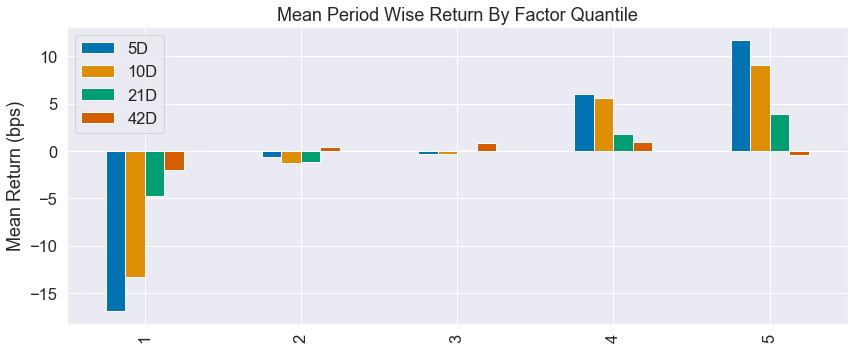

In [14]:
create_summary_tear_sheet(alphalens_data)

## 按因子分位数预测性能 - 回报分析

作为第一步，我们想通过因子分位数可视化平均周期回报。我们可以使用来自性能的内置函数 mean_return_by_quantile 和来自绘图模块的 plot_quantile_returns_bar

In [15]:
mean_return_by_q, std_err = mean_return_by_quantile(alphalens_data)
mean_return_by_q_norm = mean_return_by_q.apply(lambda x: x.add(1).pow(1/int(x.name[:-1])).sub(1))

### 持有期和五分位数的平均回报

结果是一个条形图，它根据因子信号的五分位数分解了四个不同持有期的远期回报的平均值。正如您所看到的，底部五分之一的人比顶部五分之一的人产生了更多的负面结果，除了最长的持有期：


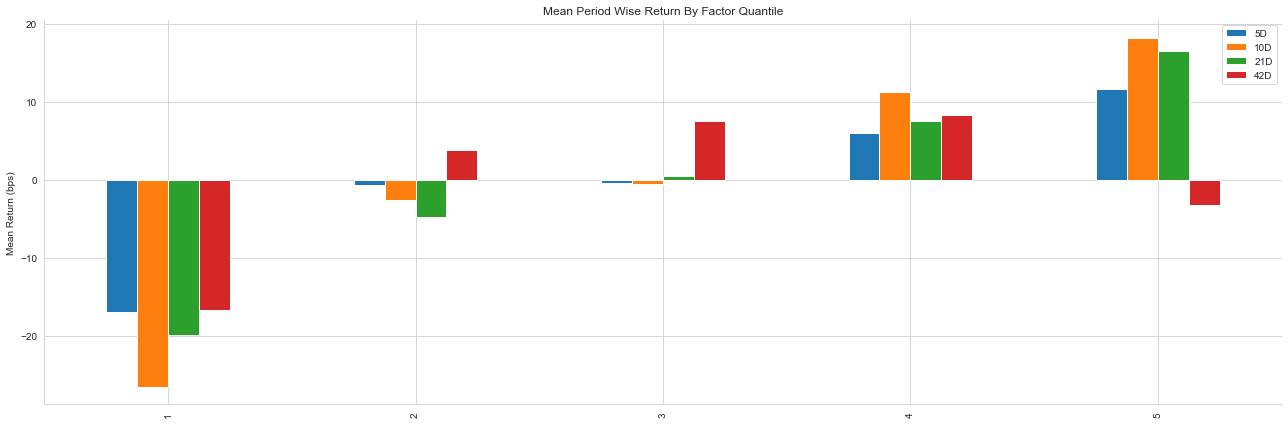

In [16]:
plot_quantile_returns_bar(mean_return_by_q)
plt.tight_layout()
sns.despine();

10天 持有期为第一和第四四分位数提供了稍微更好的结果。我们还希望看到由每个信号五分位数驱动的投资随时间推移的表现。

我们将每天计算，而不是 5天 持有期的平均回报，alphalens 将调整周期回报以解决每日信号与较长持有期之间的不匹配（有关详细信息，请参阅文档）：


In [17]:
mean_return_by_q_daily, std_err = mean_return_by_quantile(alphalens_data, by_date=True)

### 累计 5日 回报

由此产生的线图显示，在这三年期间的大部分时间里，前两个五分之一的人的表现明显优于后两个五分之一的人。然而，如上图所示，第四个五分位数的信号产生的性能优于前五分之一的信号

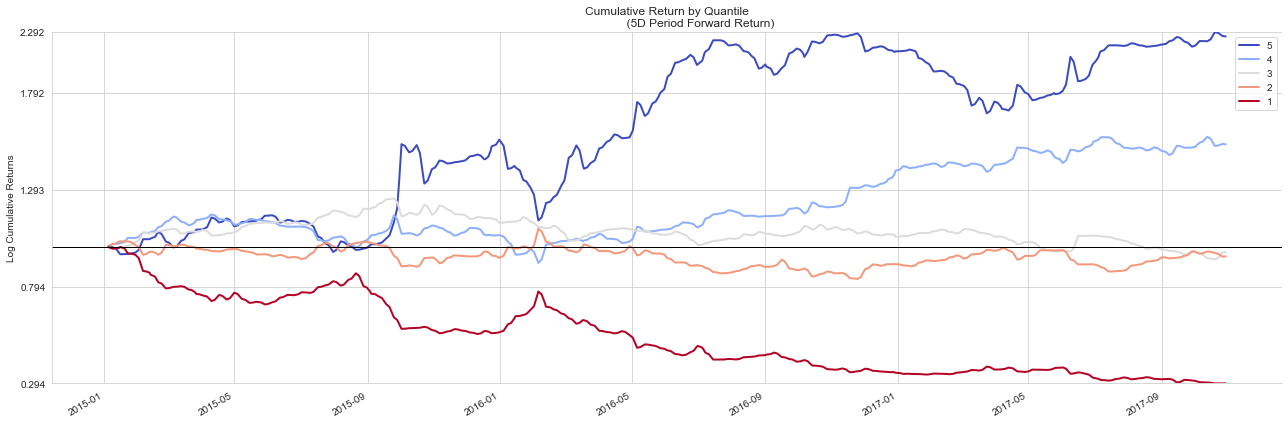

In [18]:
plot_cumulative_returns_by_quantile(mean_return_by_q_daily['5D'], period='5D', freq=None)
plt.tight_layout()
sns.despine();

### 按持有期和五分位划分的回报分布

该分布图强调每日回报的范围相当广泛，尽管采用不同的方式，但分布的分离非常有限，因此在任何给定的一天，不同五分位数之间的表现差异可能相当有限：

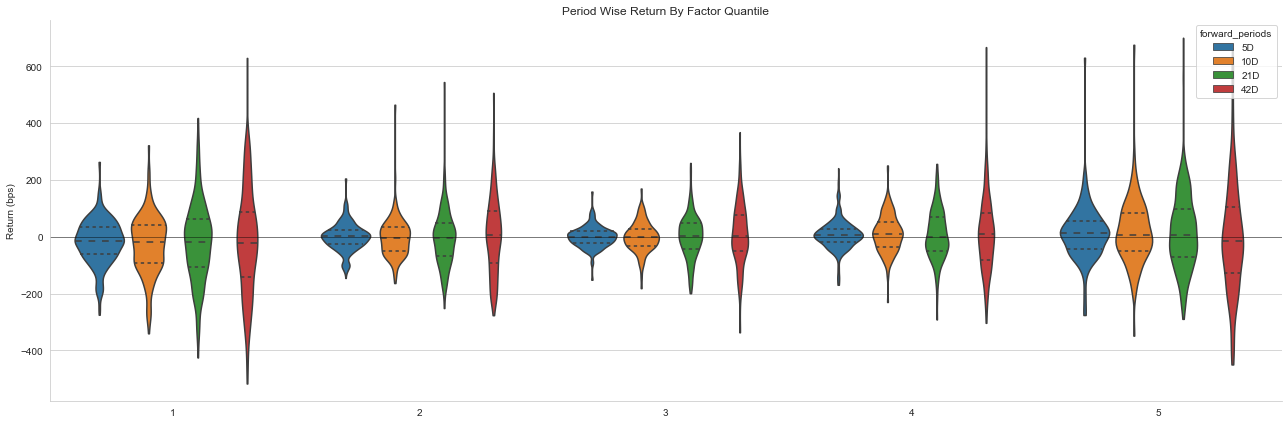

In [19]:
plot_quantile_returns_violin(mean_return_by_q_daily)
plt.tight_layout()
sns.despine();

## 信息系数

本书的大部分内容都是关于使用 ML 模型设计 alpha 因子的。 ML 是关于优化一些预测目标，在本节中，我们将介绍用于衡量 alpha 因素性能的关键指标。我们将 alpha 定义为超过基准的平均回报。
这导致信息比率 (IR) 通过将 alpha 除以跟踪风险来衡量每单位风险的平均超额回报。当基准是无风险利率时，IR 对应于众所周知的夏普比率，我们将重点介绍在回报不呈正态分布的典型情况下出现的关键统计测量问题。我们还将解释主动管理的基本法则，该法则将 IR 分解为预测技能和有效利用预测技能的策略能力的组合。


### 5D 信息系数（滚动平均）。


alpha 因子的目标是对未来回报进行准确的方向性预测。因此，自然的绩效衡量标准是 alpha 因子的预测与目标资产的远期回报之间的相关性。

最好使用非参数 Spearman 等级相关系数，它衡量两个变量之间的关系可以用单调函数描述的程度，而不是 Pearson 相关系数，后者衡量线性关系的强度。

我们可以使用 alphalens 获取信息系数，它依赖于引擎盖下的 `scipy.stats.spearmanr`。

`factor_information_coefficient` 函数计算周期相关性，plot_ic_ts 创建具有一个月移动平均值的时间序列图：

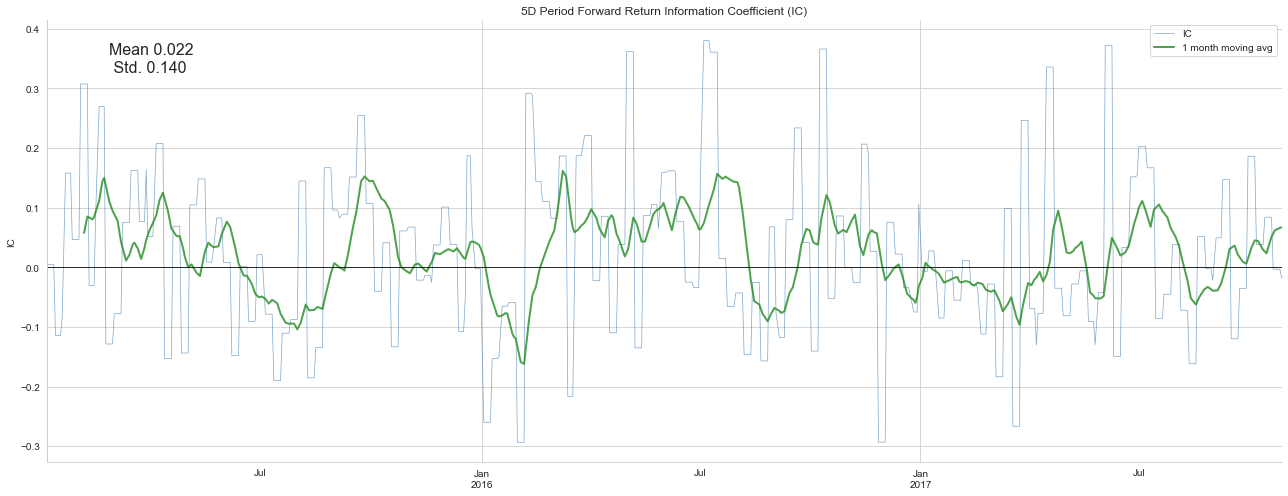

In [20]:
ic = factor_information_coefficient(alphalens_data)
plot_ic_ts(ic[['5D']])
plt.tight_layout()
sns.despine();

### 按持有期划分的信息系数

此时间序列图显示了具有显着正移动平均 IC 的延长期。如果有足够的机会应用这种预测技巧，0.05 甚至 0.1 的 IC 允许显着的表现，主动管理的基本法则将说明：

年度平均 IC 图突出了该因子的表现在历史上是如何不平衡的：

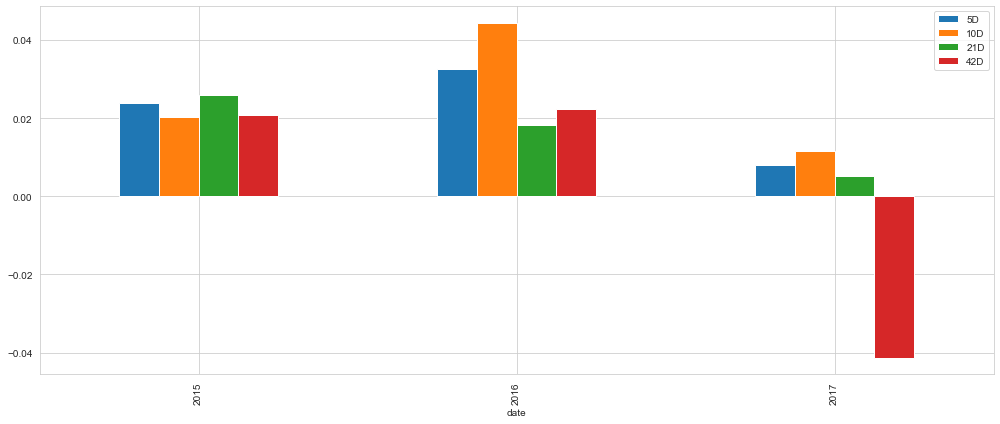

In [21]:
ic = factor_information_coefficient(alphalens_data)
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year
ic_by_year.plot.bar(figsize=(14, 6))
plt.tight_layout();

## 营业额撕单

因子周转率衡量资产与给定分位数变化相关联的频率，即根据信号序列调整投资组合所需的交易次数。更具体地说，它衡量的是当前处于一个因子分位数中但在上一时期不在该分位数中的资产份额。

Turnover Analysis


,5D,10D,21D,42D
Quantile 1 Mean Turnover,0.411,0.590,0.830,0.831
Quantile 2 Mean Turnover,0.645,0.740,0.804,0.812
Quantile 3 Mean Turnover,0.679,0.765,0.808,0.812
Quantile 4 Mean Turnover,0.642,0.741,0.810,0.814
Quantile 5 Mean Turnover,0.394,0.569,0.811,0.819


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.013,-0.017


<Figure size 432x288 with 0 Axes>

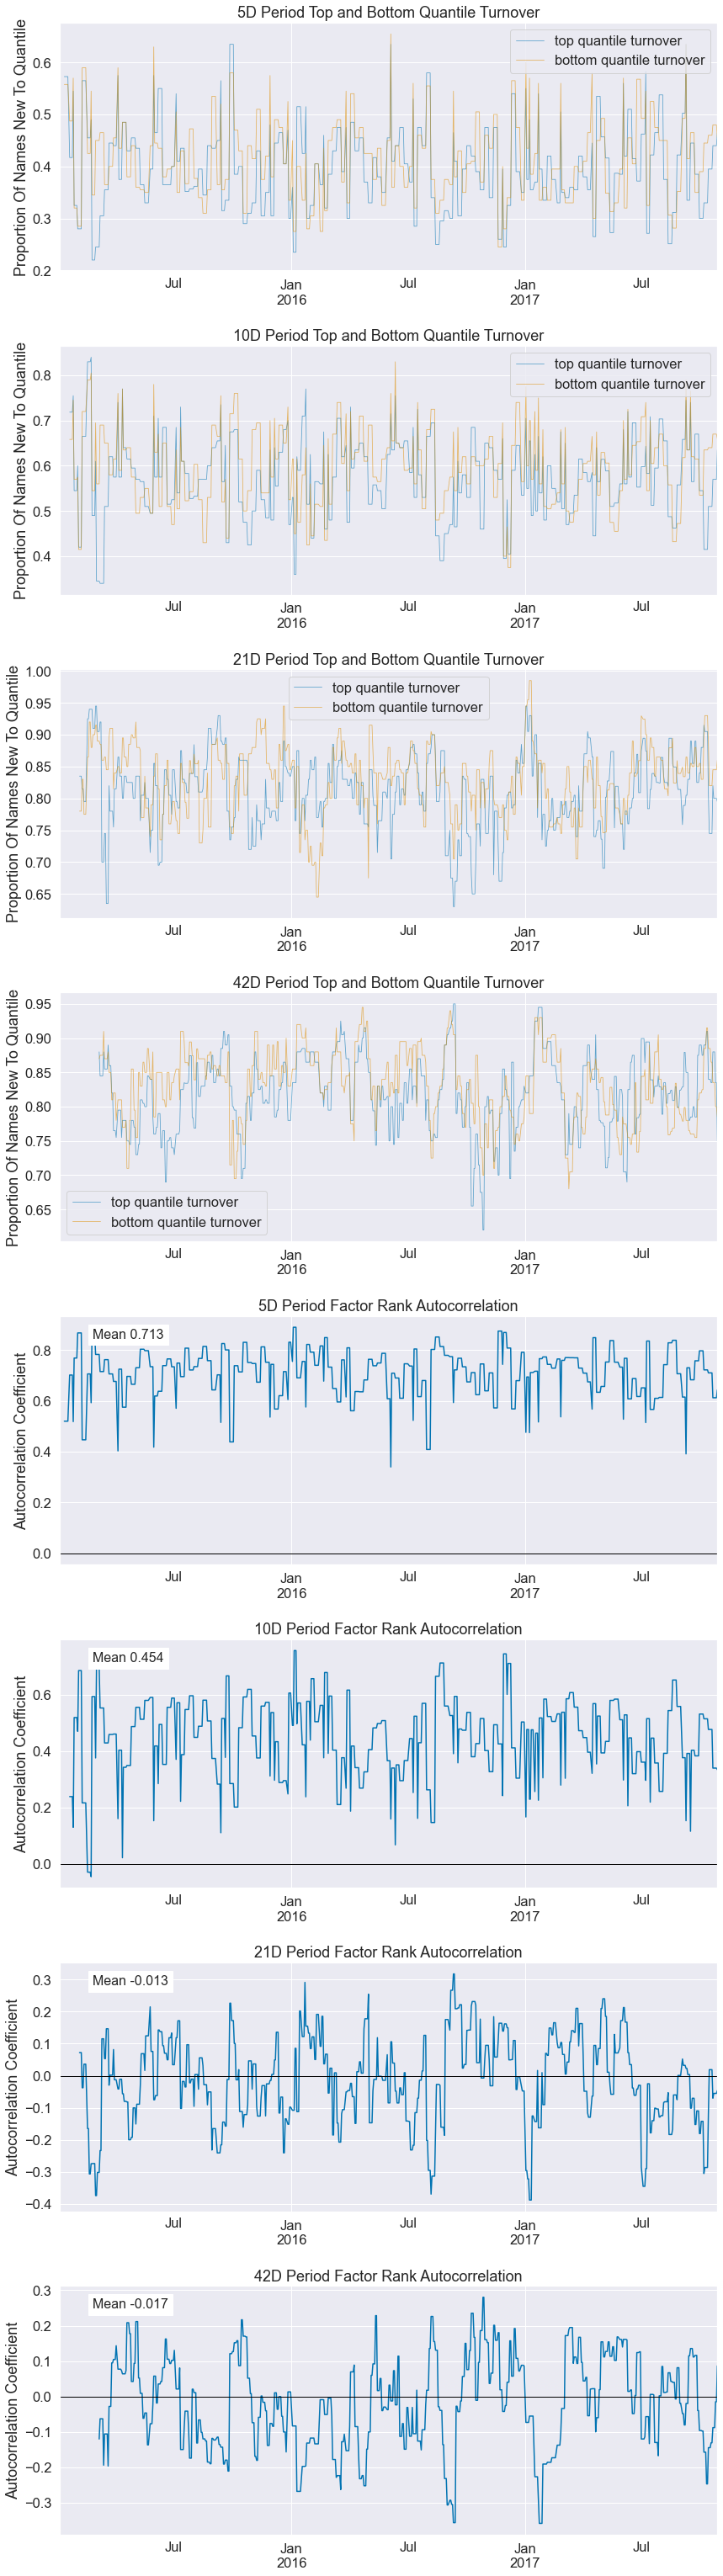

In [22]:
create_turnover_tear_sheet(alphalens_data);